In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn import datasets as dt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

import pandas as pd
import numpy as np
import seaborn as sns


import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

from skimage.io import imread, imshow

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

### Load Data

(374, 500, 3)


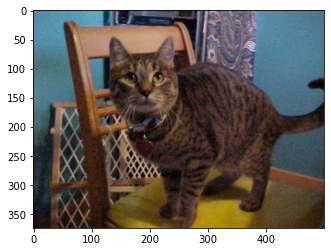

In [2]:
image = mpimg.imread("archive/animals/cats/cats_00001.jpg")
print(image.shape)
plt.imshow(image)
plt.show()

# import PIL
# image = np.asarray(PIL.Image.open("archive/animals/cats/cats_00001.jpg"))
# image_raw = image.reshape(561000,)

In [3]:
cat = []
for i in range(1,1001):
    try:
        image = mpimg.imread("archive/animals/cats/cats_"+'{0:05}'.format(i)+".jpg")
        if image.shape == (374, 500, 3):
            image_cat = image.reshape(561000,)
            cat.append(image_cat)
        else: pass
    except: pass

    
dog = []
for i in range(1,1001):
    try:
        image = mpimg.imread("archive/animals/dogs/dogs_"+'{0:05}'.format(i)+".jpg")
        if image.shape == (374, 500, 3):
            image_dog = image.reshape(561000,)
            dog.append(image_dog)
    except: pass
    
panda = []
for i in range(1,1001):
    try:
        image = mpimg.imread("archive/animals/panda/panda_"+'{0:05}'.format(i)+".jpg")
        if image.shape == (374, 500, 3):
            image_panda = image.reshape(561000,)
            panda.append(image_panda)
    except: pass
    
print(len(cat),len(dog),len(panda))

135 108 3


In [4]:
df_cat = pd.DataFrame(cat)
df_dog = pd.DataFrame(dog)
df_panda = pd.DataFrame(panda)

df = pd.concat([df_cat,df_dog,df_panda])
df.reset_index()
label = [1]*135 + [2]*108 + [3]*3
df['label'] = label
df.to_csv('dogcatpanda.csv')

In [5]:
y = df.label.values
X = df.drop("label",axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

print(y.shape)

(246,)


### Attack class


In [6]:
class Attack:

    def __init__(self, model):
        self.fooling_targets = None
        self.model = model
    
    def prepare(self, X_train, y_train, X_test, y_test):
        self.images = X_test
        self.true_targets = y_test
        self.num_samples = X_test.shape[0]
        self.train(X_train, y_train)
        print("Model training finished.")
        self.test(X_test, y_test)
        print("Model testing finished. Initial accuracy score: " + str(self.initial_score))
    
    def set_fooling_targets(self, fooling_targets):
        self.fooling_targets = fooling_targets
    
    def train(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        self.weights = self.model.coef_
        self.num_classes = self.weights.shape[0]

    def test(self, X_test, y_test):
        self.preds = self.model.predict(X_test)
        self.preds_proba = self.model.predict_proba(X_test)
        self.initial_score = accuracy_score(y_test, self.preds)
    
    def create_one_hot_targets(self, targets):
        self.one_hot_targets = np.zeros(self.preds_proba.shape)
        print(self.preds_proba.shape)
        print(targets.shape)
        for n in range(targets.shape[0]):
            self.one_hot_targets[n, targets[n]-1] = 1
            
    def attack(self, attackmethod, epsilon):
        perturbed_images, highest_epsilon = self.perturb_images(epsilon, attackmethod)
        perturbed_preds = self.model.predict(perturbed_images)
        self.perturbed_confidence = self.model.predict_proba(perturbed_images)
        score = accuracy_score(self.true_targets, perturbed_preds)
        return perturbed_images, perturbed_preds, score, highest_epsilon
    
    def perturb_images(self, epsilon, gradient_method):
        perturbed = np.zeros(self.images.shape)
        max_perturbations = []
        for n in range(self.images.shape[0]):
            perturbation = self.get_perturbation(epsilon, gradient_method, self.one_hot_targets[n], self.preds_proba[n])
            perturbed[n] = self.images[n] + perturbation
            max_perturbations.append(np.max(perturbation))
        highest_epsilon = np.max(np.array(max_perturbations))
        return perturbed, highest_epsilon
    
    def get_perturbation(self, epsilon, gradient_method, target, pred_proba):
        if gradient_method == 'FGSM1':
            dlt = pred_proba - target
            gradient = np.matmul(dlt, self.weights)
            gradient = np.sign(gradient)
        else:
            gradient = gradient_method(target, pred_proba, self.weights)
        inf_norm = np.max(gradient)
        perturbation = epsilon/inf_norm * gradient
        return perturbation
    
    def attack_to_max_epsilon(self, attackmethod, max_epsilon):
        self.max_epsilon = max_epsilon
        self.scores = []
        self.epsilons = []
        self.perturbed_images_per_epsilon = []
        self.perturbed_outputs_per_epsilon = []
        for epsilon in range(0, self.max_epsilon):
            perturbed_images, perturbed_preds, score, highest_epsilon = self.attack(attackmethod, epsilon)
            confidence = 0
            self.epsilons.append(highest_epsilon)
            self.scores.append(score)
            self.perturbed_images_per_epsilon.append(perturbed_images)
            self.perturbed_outputs_per_epsilon.append(perturbed_preds)

### Attack methods 

In [7]:
def calc_output_weighted_weights(output, w):
    for c in range(len(output)):
        if c == 0:
            weighted_weights = output[c] * w[c]
        else:
            weighted_weights += output[c] * w[c]
    return weighted_weights

def non_targeted_gradient(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (1-target[k]) * (w[k]-ww)
        else:
            gradient += (1-target[k]) * (w[k]-ww)
    return gradient
    
def non_targeted_sign_gradient(target, output, w):
    gradient = non_targeted_gradient(target, output, w)
    return np.sign(gradient)

def FGSM2(target, output, w):
    ww = calc_output_weighted_weights(output, w)
    for k in range(len(target)):
        if k == 0:
            gradient = (-target[k]) * (w[k]-ww)
        else:
            gradient += (-target[k]) * (w[k]-ww)
    return gradient

## [non-targeted attack]


In [8]:
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

attack = Attack(model)
attack.prepare(X_train, y_train, X_test, y_test)
weights = attack.weights


Model training finished.
Model testing finished. Initial accuracy score: 0.494949494949495


In [9]:
attack.create_one_hot_targets(y_test)
attack.attack_to_max_epsilon(non_targeted_gradient, 20)
non_targeted_scores = attack.scores

(99, 3)
(99,)


Text(0.5, 1.0, 'Accuracy score breakdown')

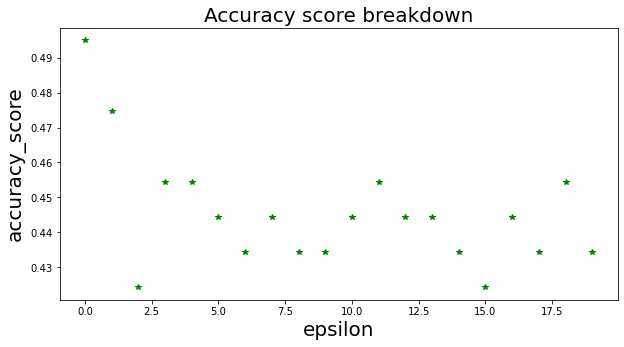

In [13]:
plt.figure(figsize=(10,5))
p1 = plt.plot(attack.epsilons, attack.scores, 'g*',label = 'Max discrepancy attack')
# p2 = plt.plot(attack2.epsilons, attack2.scores, 'r*',label = 'FGSM attack')
plt.ylabel('accuracy_score',fontsize = 20)
plt.xlabel('epsilon',fontsize = 20)
# ax = plt.subplot(111)
# ax.legend(fontsize = 15)
# ax.legend((p1,p2),('max discrepancy attack','FGSM'))
plt.title('Accuracy score breakdown',fontsize = 20)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


3.0000000000000004
(109, 4)
(15, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


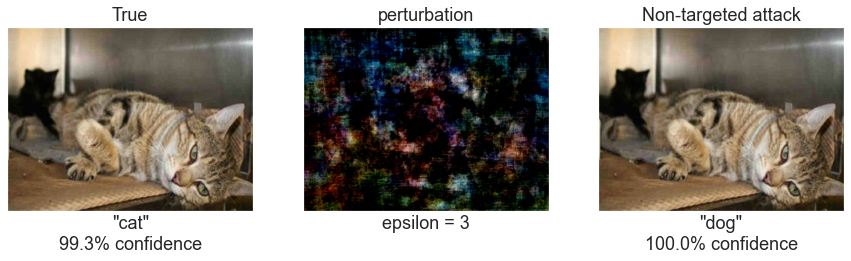

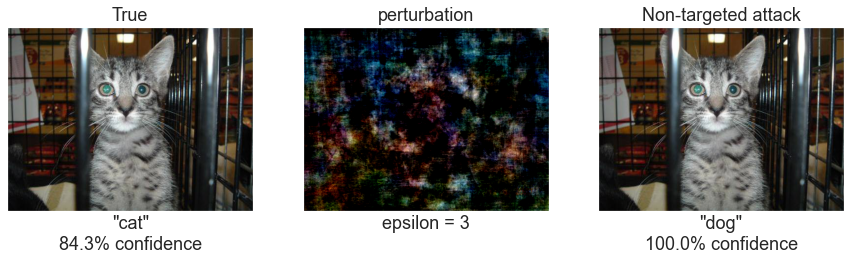

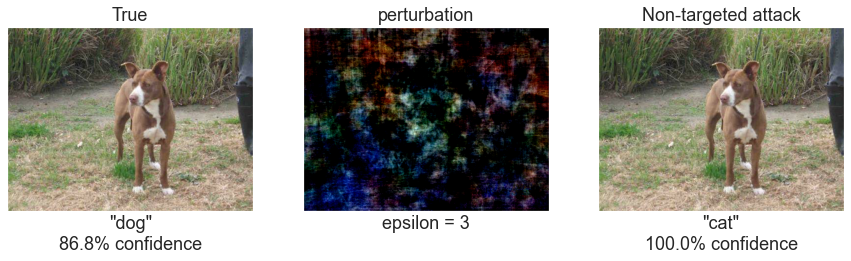

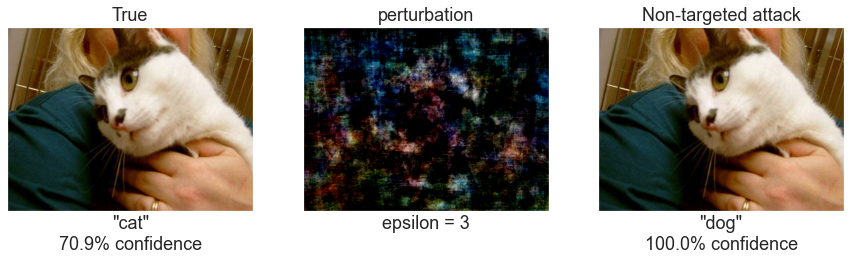

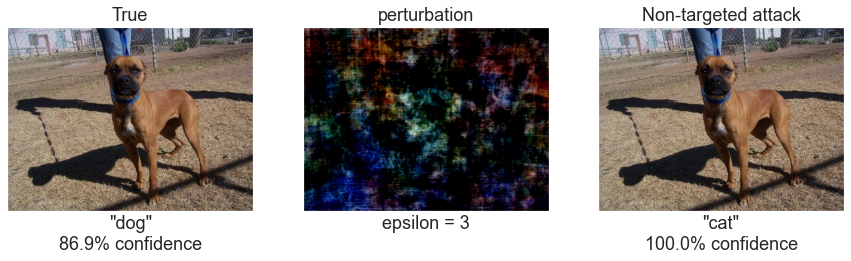

In [34]:
eps = 3
print(attack.epsilons[eps])

example_images = attack.perturbed_images_per_epsilon[eps]
example_preds = attack.perturbed_outputs_per_epsilon[eps]

example_results = pd.DataFrame(data=attack.true_targets, columns=['y_true'])
example_results['y_fooled'] = example_preds
example_results['y_predicted'] = attack.preds
example_results['id'] = example_results.index.values

print(example_results.shape)

success_df = example_results[example_results.y_true != example_results.y_fooled]
success_df = success_df[success_df.y_true == success_df.y_predicted]
print(success_df.shape)

label_names = ['0','cat','dog','panda']

def show3images(n, epsilon):
    
    example_id = success_df.id.values[n]
    example_confidence = attack.preds_proba[example_id]
    example_confidence2 = attack.perturbed_confidence[example_id]

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15,4))
    
    rgb1 = X_test[example_id]  
    img1 = rgb1.reshape(374,500,3)
    axA.imshow(img1)
    axA.set_title("True",fontsize = 18)
    axA.set_xlabel("\""+label_names[y_test[example_id]]+"\""+"\n{:.1f}".format(np.max(example_confidence)*100)+'% confidence',fontsize = 18)
    axA.grid(False)
    axA.set_xticks([])
    axA.set_yticks([])
    
    rgb2 = example_images[example_id]/255.0
    img2 = rgb2.reshape(374,500,3)
    axC.imshow(img2)
    axC.set_title("Non-targeted attack",fontsize=18)
    axC.set_xlabel("\""+label_names[example_preds[example_id]]+"\""+"\n{:.1f}".format(np.max(example_confidence2)*100)+'% confidence',fontsize = 18)
    axC.grid(False)
    axC.set_xticks([])
    axC.set_yticks([])
    
    
    rgb3 = (example_images[example_id] - X_test[example_id])/eps
    img3 = rgb3.reshape(374,500,3) 
    axB.imshow(img3)
    axB.set_title("perturbation",fontsize = 18)
    axB.set_xlabel("epsilon = %d" %eps,fontsize =18)
    axB.grid(False)
    axB.set_xticks([])
    axB.set_yticks([])

for i in range(10,15):
    show3images(i,eps)

## [FGSM]

In [11]:
from sklearn.linear_model import LogisticRegression
model2 = LogisticRegression(multi_class='multinomial', solver='lbfgs', fit_intercept=False)

attack2 = Attack(model2)
attack2.prepare(X_train, y_train, X_test, y_test)
weights2 = attack2.weights


attack2.create_one_hot_targets(y_test)
attack2.attack_to_max_epsilon(FGSM2, 30)
non_targeted_scores2 = attack2.scores

Model training finished.
Model testing finished. Initial accuracy score: 0.494949494949495
(99, 3)
(99,)


NameError: name 'FGSM2' is not defined

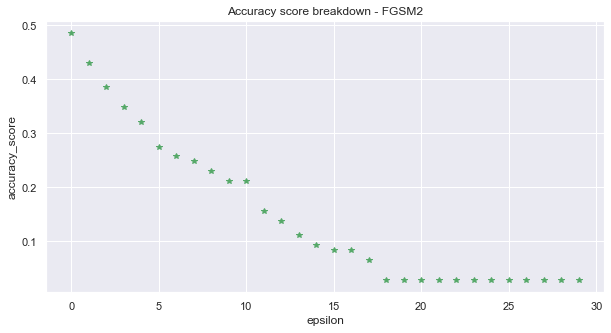

In [36]:
sns.set()
plt.figure(figsize=(10,5))
plt.plot(attack2.epsilons, attack2.scores, 'r*')
plt.ylabel('accuracy_score')
plt.xlabel('epsilon')
plt.title('Accuracy score breakdown - FGSM');

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

1.0
(109, 4)
(6, 4)


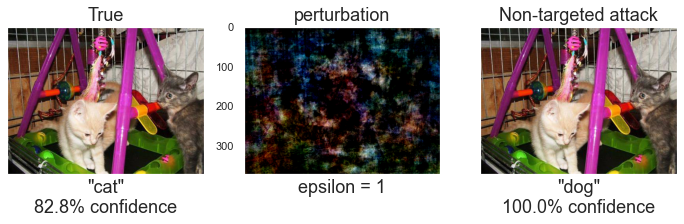

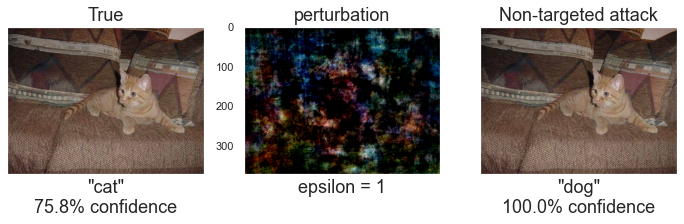

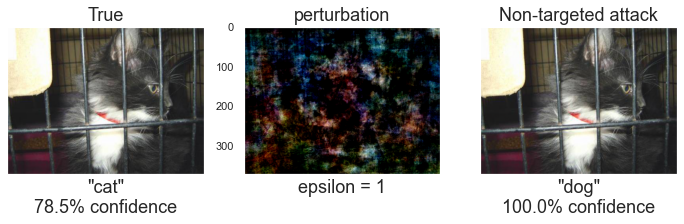

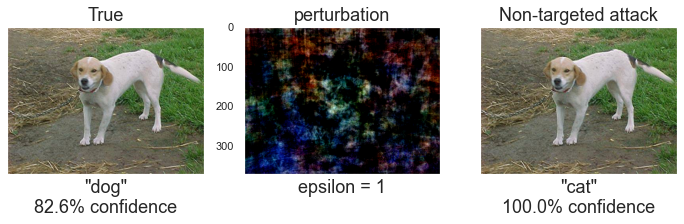

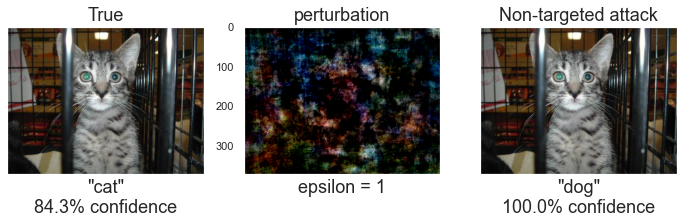

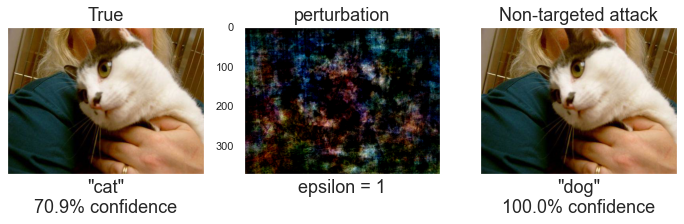

In [41]:
eps = 1
print(attack2.epsilons[eps])

example_images2 = attack2.perturbed_images_per_epsilon[eps]
example_preds2 = attack2.perturbed_outputs_per_epsilon[eps]

example_results2 = pd.DataFrame(data=attack2.true_targets, columns=['y_true'])
example_results2['y_fooled'] = example_preds2
example_results2['y_predicted'] = attack2.preds
example_results2['id'] = example_results2.index.values

print(example_results2.shape)

success_df2 = example_results2[example_results2.y_true != example_results2.y_fooled]
success_df2 = success_df2[success_df2.y_true == success_df2.y_predicted]
print(success_df2.shape)

label_names = ['0','cat','dog','panda']

def show3images2(n, epsilon):
    
    example_id = success_df2.id.values[n]
    example_confidence = attack2.preds_proba[example_id]
    example_confidence2 = attack2.perturbed_confidence[example_id]

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(12,4))
    
    rgb1 = X_test[example_id]  
    img1 = rgb1.reshape(374,500,3)
    axA.imshow(img1)
    axA.set_title("True",fontsize = 18)
    axA.set_xlabel("\""+label_names[y_test[example_id]]+"\""+"\n{:.1f}".format(np.max(example_confidence)*100)+'% confidence',fontsize = 18)
    axA.grid(False)
    axA.set_xticks([])
    axA.set_yticks([])
    
    rgb2 = example_images[example_id]/255.0
    img2 = rgb2.reshape(374,500,3)
    axC.imshow(img2)
    axC.set_title("Non-targeted attack",fontsize=18)
    axC.set_xlabel("\""+label_names[example_preds[example_id]]+"\""+"\n{:.1f}".format(np.max(example_confidence2)*100)+'% confidence',fontsize = 18)
    axC.grid(False)
    axC.set_xticks([])
    axC.set_yticks([])
    
    
    rgb3 = (example_images[example_id] - X_test[example_id])/eps
    img3 = rgb3.reshape(374,500,3) 
    axB.imshow(img3)
    axB.set_title("perturbation",fontsize = 18)
    axB.set_xlabel("epsilon = %d" %eps,fontsize =18)
    axB.grid(False)
    axB.set_xticks([])

for i in range(6):
    show3images2(i,eps)